In [1]:
from urllib.request import urlopen
from urllib.error import HTTPError, URLError
from bs4 import BeautifulSoup
import re
import pandas as pd
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np
import matplotlib.pyplot as plt
import seaborn

seaborn.set(style='ticks')

parser = 'lxml'

separator = re.compile(r'---{3,}')
congress = re.compile(r'((\d{1,3})\w{2}\sCongress)\s\((\d{4})-(\d{4})\)')
majority = re.compile(r'Majority Party.*:\s(.*)\s\((\d*)')
minority = re.compile(r'Minority Party.*:\s(.*)\s\((\d*)')
other = re.compile(r'Other Parties.*:\s(.*)')
total = re.compile(r'Total Seats: (\d{1,3})')

# Quick Visualization - US Senate and House Partisanship over Time

The goal of this notebook is to make a quick visualization of data from the [Senate Party Division](https://www.senate.gov/history/partydiv.htm) page and the [House Party Divisions](http://history.house.gov/Institution/Party-Divisions/Party-Divisions/) page. The data is present on both pages in tabular form, but needs to be scraped. We'll try two methods:
1. `urllib` with `BeautifulSoup`
2. the `pandas.read_html()` method

We'll use the first method on the Senate data and the second for the House.

# Senate Partisanship

## Scraping the data

We'll first need to define two variables to hold the URLs for the data sources. 

In [2]:
senate = 'https://www.senate.gov/history/partydiv.htm'
house = 'http://history.house.gov/Institution/Party-Divisions/Party-Divisions/'

We'll then define four functions: `get_html`, `get_tag`, `break_apart` and `other_party_filter`.
* `get_html` uses the `urllib` library to get the HTML from the Senate webpage and contains basic error handling
* `get_tag` will parse the HTML for the specific HTML tag that we're looking for and let the user know if the tag is missing in the data
* `break_apart` splits the data into individual entries from the HTML table
* `other_party_filter` will extract any third + parties that were present in the data. For example, in the 34th Congress the data includes:
> Other Parties: 1 American Party; 1 Republican

The function will capture the data as a tuple in the form (party, seats)

In [3]:
def get_html(url):
    try:
        return urlopen(url)
    except HTTPError as e:
        print('{} --> {}'.format(e,url))
    except URLError:
        print('Server not found.')
        
def get_tag(tag):
    try:
        if tag is not None:
            return tag
        print('Tag not found!')
    except AttributeError:
        print('Tag not found!')
        
def break_apart(item):
    _final = []
    for element in item:
        if len(element) == 1:
            _final.extend([list(filter(None,i.split('\n'))) for i in element])
        else:
            _final.append(element)
    return _final


def other_party_filter(data):
    _data = []
    for datum in data:
        _datum = []
        if len(datum[0]) != 1:
            for i in datum:
                extract = re.search(r'^\s?(\d{1,3})\s(.+)\s?\(?',i)
                if extract == None:
                    extract = re.search(r'^(\w*)\s\((\d) seat',i)
                extract = sorted(filter(None, [extract.group(1), extract.group(2)]))
                _datum.append((re.sub(r'\s\(.*\)', '',extract[1]).strip(),int(extract[0])))
        else:
            _datum.append(('None', int(datum[0])))
        _data.append(_datum)
    return _data

First we'll get the Senate data and parse it with `BeautifulSoup`. The parser we're using is `lxml`. The parser and the regular expressions are defined in the import cell at the top of the notebook.

In [4]:
senate_html = get_html(senate)
bs_senate = BeautifulSoup(senate_html.read(), parser)

senate_list = '::'.join([i.get_text() for i in get_tag(bs_senate.findAll('p'))])
senate_list = re.split(separator, senate_list)
senate_list = [list(filter(None,i.split('::'))) for i in senate_list]
senate_list = break_apart(senate_list[1:-2])
senate_list[0]

['\n1st Congress (1789-1791)\n',
 'Majority Party: Pro-Administration (18 seats)',
 'Minority Party: Anti-Administration (8 seats)',
 'Other Parties: 0',
 'Total Seats: 26',
 'Note: Organized political parties developed in the U.S. in the 1790s, but political factions--from which organized parties evolved--began to appear almost immediately after establishment of the federal government. Those who supported the Washington administration were referred to as "pro-administration" and would eventually form the Federalist party, while those in opposition joined the emerging (Jeffersonian) Republican party.']

We need to replace the `&nbsp;` in the HTML to continue processing properly. The unicode character that we're looking for is `/xa0`. This analysis was orginally done in Python 2 and then switched to Python 3. The unicode problem is handled automatically in Python 3, so this code is a remnant.

In [5]:
congress_list = [i[0].strip().replace(u'\xa0', u'') for i in senate_list[:len(senate_list)]]
majority_party = [i[1].strip().replace(u'\xa0', u'') for i in senate_list[:len(senate_list)]]
minority_party = [i[2].strip().replace(u'\xa0', u'') for i in senate_list[:len(senate_list)]]
other_party = [i[3].strip().replace(u'\xa0', u'') for i in senate_list[:len(senate_list)]]
total_seats = [i[4].strip().replace(u'\xa0', u'') for i in senate_list[:len(senate_list)]]

# Sanity check
for each in [congress_list, majority_party, minority_party, other_party, total_seats]:
    assert len(each) == 115

We'll process the data into tuples that are generally of the form `(party, seats)`. We'll also process the tuples into a Pandas DataFrame.

In [6]:
congress_tuples = [(congress.search(i).group(2),congress.search(i).group(1),
                    int(congress.search(i).group(3)),
                    int(congress.search(i).group(4))) for i in congress_list]
minority_tuples = [(minority.search(i).group(1),
                    int(minority.search(i).group(2))) for i in minority_party]
majority_tuples = [(majority.search(i).group(1),
                    int(majority.search(i).group(2))) for i in majority_party]
other_tuples = [other.search(i).group(1) for i in other_party]
other_tuples = other_party_filter([i.split(';') for i in other_tuples])
total_seats = list(map(lambda x: int(x.group(1)) if x != None else None, 
                       [re.search(r'Total Seats: (\d{1,})', i) for i in total_seats]))

df = pd.concat([pd.DataFrame([x[1:] for x in congress_tuples]),
                pd.DataFrame([x for x in majority_tuples]),
               pd.DataFrame([x for x in minority_tuples]),
                pd.DataFrame([x for x in total_seats])], axis=1)
df.columns = ['Congress', 'Start Year', 'End Year', 'Majority Party',
              'Majority Seats', 'Minority Party',
              'Minority Seats', 'Total Seats']
df.set_index('Congress', inplace=True)
df.head()

Start Year  End Year      Majority Party  Majority Seats  \
Congress                                                                 
1st Congress        1789      1791  Pro-Administration              18   
2nd Congress        1791      1793  Pro-Administration              16   
3rd Congress        1793      1795  Pro-Administration              16   
4th Congress        1795      1797          Federalist              21   
5th Congress        1797      1799          Federalist              22   

                   Minority Party  Minority Seats  Total Seats  
Congress                                                        
1st Congress  Anti-Administration               8         26.0  
2nd Congress  Anti-Administration              13         30.0  
3rd Congress  Anti-Administration              14         30.0  
4th Congress           Republican              11         32.0  
5th Congress           Republican              10         32.0

Some values were not processed correctly because there were vacant seats in certain years and those values needed to be added manually. In addition, we'll convert the number of seats to a percentage so that it was comparable as the number of seats changed.

In [7]:
#Fill in Missing Totals Manually
df.set_value('7th Congress','Total Seats', 34)
df.set_value('27th Congress','Total Seats', 52)
df.set_value('56th Congress','Total Seats', 90)
df.set_value('70th Congress','Total Seats', 96)
print(df.loc[["7th Congress",'27th Congress','56th Congress','70th Congress']]["Total Seats"])

df['% Majority'] = df['Majority Seats']/df['Total Seats']*100
df['% Minority'] = df['Minority Seats']/df['Total Seats']*100

df.head()

Congress
7th Congress     34.0
27th Congress    52.0
56th Congress    90.0
70th Congress    96.0
Name: Total Seats, dtype: float64


Start Year  End Year      Majority Party  Majority Seats  \
Congress                                                                 
1st Congress        1789      1791  Pro-Administration              18   
2nd Congress        1791      1793  Pro-Administration              16   
3rd Congress        1793      1795  Pro-Administration              16   
4th Congress        1795      1797          Federalist              21   
5th Congress        1797      1799          Federalist              22   

                   Minority Party  Minority Seats  Total Seats  % Majority  \
Congress                                                                     
1st Congress  Anti-Administration               8         26.0   69.230769   
2nd Congress  Anti-Administration              13         30.0   53.333333   
3rd Congress  Anti-Administration              14         30.0   53.333333   
4th Congress           Republican              11         32.0   65.625000   
5th Congress           Republican              10         32.0   68.750000   

              % Minority  
Congress                  
1st Congress   30.769231  
2nd Congress   43.333333  
3rd Congress   46.666667  
4th Congress   34.375000  
5th Congress   31.250000

### Plotting the data
Let's plot the % Majority and Minority data versus the Year.

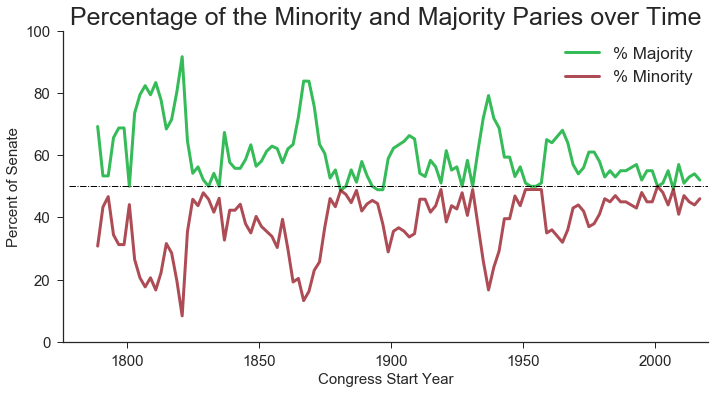

In [8]:
plt.figure(figsize=(7, 5),dpi=300)
fg = seaborn.FacetGrid(data=df[['% Majority','% Minority','Start Year']],
                    size=5, aspect=2, ylim=(0,100),xlim=(1776, 2020))
fg.map(plt.plot, 'Start Year', '% Majority',
       alpha =0.8, linewidth='3', 
       color='xkcd:kelly green', label='% Majority')
fg.map(plt.plot, 'Start Year', '% Minority',
       alpha =0.7, linewidth='3',
       color='xkcd:crimson', label='% Minority')
plt.plot([1778, 2020], [50, 50], 'k-.', lw=1)
plt.ylabel('Percent of Senate', fontsize=15)
plt.yticks(size=15)
plt.xticks(size=15)
plt.xlabel('Congress Start Year', fontsize=15)
plt.legend(fontsize=17)
plt.subplots_adjust(top=1.0)
plt.title('Percentage of the Minority and Majority Paries over Time', fontsize=25)
plt.savefig('Percentage of the Minority and Majority Paries over Time.png', bbox_inches='tight')
plt.savefig('Percentage of the Minority and Majority Paries over Time.pdf', bbox_inches='tight')

The plot doesn't show much that's useful to us, but it does show us that the fluctuations from one party to another appear to have decreased in magnitude. We should plot the difference between the majority and minority parties over time. If we define the partisan difference as majority percentage - minority percentage, we can guarantee a positive answer. The color was chosen by subtracting `xkcd:crimson` (#8c000f) from `xkcd:kelly green` (#02ab2e) using [ColorHexa](http://www.colorhexa.com/), the same way we defined partisan difference.

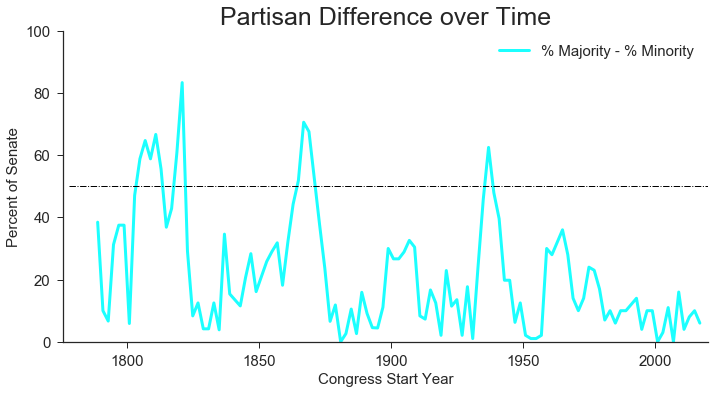

In [9]:
df['Partisan Difference'] = df['% Majority'] - df['% Minority']

plt.figure(figsize=(7, 5),dpi=300)
seaborn.set_palette(seaborn.color_palette("tab20b", 8))
fg = seaborn.FacetGrid(data=df[['Partisan Difference','Start Year']],
                    size=5, aspect=2, ylim=(0,100),xlim=(1776, 2020))
fg.map(plt.plot, 'Start Year', 'Partisan Difference',
       alpha =0.9,linewidth='3',
       color='#03ffff', label='% Majority - % Minority')
plt.plot([1778, 2020], [50, 50], 'k-.', lw=1)
plt.yticks(size=15)
plt.ylabel('Percent of Senate', fontsize=15)
plt.xticks(size=15)
plt.xlabel('Congress Start Year', fontsize=15)
plt.legend(fontsize=15)
plt.subplots_adjust(top=1.0)
plt.title('Partisan Difference over Time', fontsize=25)
plt.savefig('Partisan Difference over Time.png', bbox_inches='tight')
plt.savefig('Partisan Difference over Time.pdf', bbox_inches='tight')

## Splitting the Data to Plot by Party

In [10]:
df.head()

Start Year  End Year      Majority Party  Majority Seats  \
Congress                                                                 
1st Congress        1789      1791  Pro-Administration              18   
2nd Congress        1791      1793  Pro-Administration              16   
3rd Congress        1793      1795  Pro-Administration              16   
4th Congress        1795      1797          Federalist              21   
5th Congress        1797      1799          Federalist              22   

                   Minority Party  Minority Seats  Total Seats  % Majority  \
Congress                                                                     
1st Congress  Anti-Administration               8         26.0   69.230769   
2nd Congress  Anti-Administration              13         30.0   53.333333   
3rd Congress  Anti-Administration              14         30.0   53.333333   
4th Congress           Republican              11         32.0   65.625000   
5th Congress           Republican              10         32.0   68.750000   

              % Minority  Partisan Difference  
Congress                                       
1st Congress   30.769231            38.461538  
2nd Congress   43.333333            10.000000  
3rd Congress   46.666667             6.666667  
4th Congress   34.375000            31.250000  
5th Congress   31.250000            37.500000

We'll split the data up into two DataFrames by making copies of the original DataFrame that only include the Majority Party information and the Minority Party information.

In [11]:
df_majority = df[['Majority Party', '% Majority', 'Start Year', 'End Year']].copy()
df_minority = df[['Minority Party', '% Minority', 'Start Year', 'End Year']].copy()

df_majority['Congress'] = df_majority.index
df_majority.rename(columns = {'Majority Party':'Party', '% Majority': 'Percent'}, inplace=True)

df_minority['Congress'] = df_minority.index
df_minority.rename(columns = {'Minority Party':'Party', '% Minority': 'Percent'}, inplace=True)
df_minority.head()

Party    Percent  Start Year  End Year  \
Congress                                                             
1st Congress  Anti-Administration  30.769231        1789      1791   
2nd Congress  Anti-Administration  43.333333        1791      1793   
3rd Congress  Anti-Administration  46.666667        1793      1795   
4th Congress           Republican  34.375000        1795      1797   
5th Congress           Republican  31.250000        1797      1799   

                  Congress  
Congress                    
1st Congress  1st Congress  
2nd Congress  2nd Congress  
3rd Congress  3rd Congress  
4th Congress  4th Congress  
5th Congress  5th Congress

In [12]:
df_majority.head()

Party    Percent  Start Year  End Year  \
Congress                                                            
1st Congress  Pro-Administration  69.230769        1789      1791   
2nd Congress  Pro-Administration  53.333333        1791      1793   
3rd Congress  Pro-Administration  53.333333        1793      1795   
4th Congress          Federalist  65.625000        1795      1797   
5th Congress          Federalist  68.750000        1797      1799   

                  Congress  
Congress                    
1st Congress  1st Congress  
2nd Congress  2nd Congress  
3rd Congress  3rd Congress  
4th Congress  4th Congress  
5th Congress  5th Congress

We'll then also append the two DataFrames to create a single DataFrame called `parties`.

In [13]:
parties = df_majority.append(df_minority)
parties.sort_values(by='Start Year', inplace=True)
group_parties = parties.groupby(by=parties['Party'])

In [14]:
parties.head()

Party    Percent  Start Year  End Year  \
Congress                                                             
1st Congress   Pro-Administration  69.230769        1789      1791   
1st Congress  Anti-Administration  30.769231        1789      1791   
2nd Congress   Pro-Administration  53.333333        1791      1793   
2nd Congress  Anti-Administration  43.333333        1791      1793   
3rd Congress   Pro-Administration  53.333333        1793      1795   

                  Congress  
Congress                    
1st Congress  1st Congress  
1st Congress  1st Congress  
2nd Congress  2nd Congress  
2nd Congress  2nd Congress  
3rd Congress  3rd Congress

## Plotting the Data by Party
First we need to create a list of the unique parties to assign the colors for the data by each Party.

In [15]:
_parties = sorted([party for party in parties['Party'].unique()])

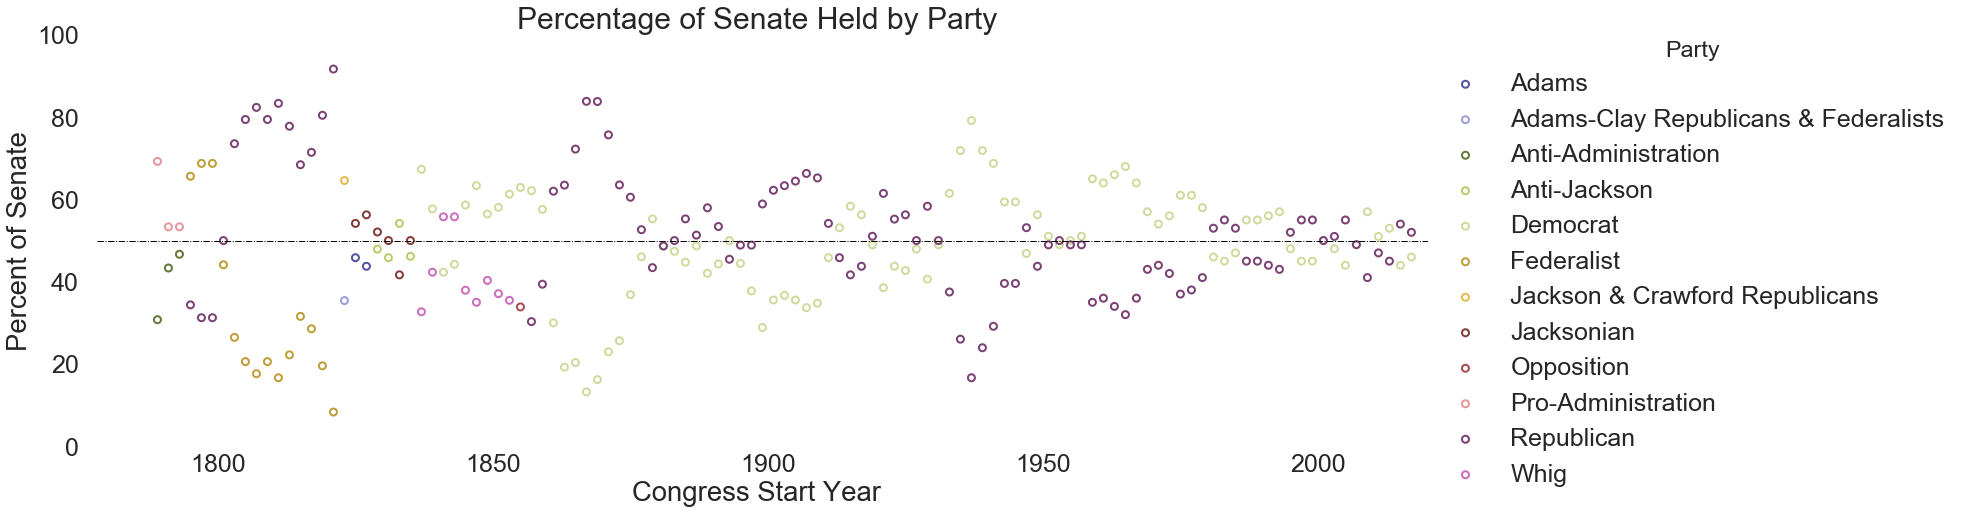

In [16]:
seaborn.set_context("poster")
plt.figure(figsize=(20, 14),dpi=1200)
seaborn.set(font_scale=2.5,rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
seaborn.set_palette(seaborn.color_palette("tab20b", len(_parties)))
fg = seaborn.FacetGrid(data=parties, hue='Party', hue_order=_parties,
                    size=7, aspect=3, ylim=(0,100),xlim=(1776, 2020))
fg.map(plt.scatter, 'Start Year', 'Percent', alpha =1.0, facecolors='none',linewidth='2')
plt.plot([1778, 2020], [50, 50], 'k-.', lw=1)
fg.add_legend()
plt.ylabel('Percent of Senate')
plt.xlabel('Congress Start Year')
plt.subplots_adjust(top=1.0)
plt.title('Percentage of Senate Held by Party')
plt.savefig('Senate Partisanship seaborn.png', bbox_inches='tight')
plt.savefig('Senate Partisanship seaborn.pdf', bbox_inches='tight')

### Plotting with differing markers
Because there are so many parties, using colors as the sole differentiation key makes the plot hard to read. Adding different markers should help alliviate the problem.

In [17]:
_markers = [x for x in '.,ov^<>8spP*h+xD']

In [18]:
_colors = seaborn.color_palette(
    'tab20b',
    len(_parties)
                                )
_party_color = {k: v for (k,v) in zip(_parties, _colors ,)}
_party_marker = {k: v for (k,v) in zip(_parties, _markers ,)}

fig, ax = plt.subplots(figsize=(30,15), dpi=600)
for party in _parties:
    x, y = parties[parties['Party'] == party]['Start Year'],\
            parties[parties['Party'] == party]['Percent']
    ax.scatter(x, y, c=_party_color[party], s = 200,
               label=party, alpha=0.9, marker=_party_marker[party])


labelsize = 33
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), ncol=5, fontsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.plot([1776, 2020], [50, 50], 'k-.', lw=2.5)
plt.tick_params(axis='both', which='major', labelsize=0.8*labelsize)
plt.title('Percentage of Senate Held by Party', fontsize=1.5*labelsize, fontweight='bold')
plt.xlabel('Congress Start Year', fontsize=labelsize)
plt.ylabel('Percent of Senate', fontsize=labelsize)
plt.axis([1776, 2020, 0, 100])
plt.savefig('Senate Partisanship with colored markers.png', bbox_inches='tight')
plt.savefig('Senate Partisanship with colored markers.pdf', bbox_inches='tight')

### Further Improvements for the Plots
To make visualization easier, Tableau, Bokeh, or D3.js could be used to make it so you can select each party individiually. Here I'll export the data to use in Tableau Public.

In [19]:
parties.to_csv('Senate Partisanship Data.csv')

# House Partisanship

Here we'll use the
second method of `pandas.read_html()`. We will ultimately need specific headers which I've stored in the `header` variable. The `read_html()` method specifically pulls the tables from a webpage and takes a URL as input and handles the call and reponse parts of URL interfacing. After the tables are pulled from the webpage, we use `house_table[0]` to deal exclusively with the table of interest (it happens to be the only table on the page).

In [20]:
header=['Congress (Years)',
            '# of House Seats',
            'Party A',
            'Party B',
            'Other',
            'Delegates/Representatives']

house_table = pd.read_html(house)
house_table = house_table[0]

We'll extend our header list to include the headings from the HTML table. We'll copy the `Del./Res.` column into a new column `Delegates/Representatives` and then reindex the table. After reindexing we can drop the `Del./Res.` column as it is no longer needed. We'll need to fix the total number of seats in the 97th index due to the superscript being read in as a regular number (436<sup>2</sup> read as 4362).

In [21]:
header.extend([x for x in house_table.columns if x not in header])
house_table['Delegates/Representatives'] = house_table['Del./Res.']
house_table = house_table.reindex(columns = header)
house_table.drop('Del./Res.', axis=1, inplace=True)
house_table.set_value(97,'# of House Seats', 436)
house_table.head()

Congress (Years)  # of House Seats  Party A  Party B  Other  \
0   1st (1789-1791)                65      NaN      NaN      0   
1   2nd (1791-1793)                69      NaN      NaN      0   
2   3rd (1793-1795)               105      NaN      NaN      0   
3  Congress (Years)  # of House Seats      NaN      NaN  Other   
4   4th (1795-1797)               106      NaN      NaN      0   

  Delegates/Representatives Pro-Administration       Anti-Administration  
0                       0/0                 37                        28  
1                       0/0                 39                        30  
2                       1/0                 51                        54  
3                 Del./Res.        Federalists  Jeffersonian Republicans  
4                       1/0                 47                        59

We need to come up with a way to move the headers, which contain the party names, into the `Party A` and `Party B` columns. We'll locate the rows that contain the headers using the `.loc[]` method and search for the string 'Congress (Years)'. Then we'll fill in the rows for the `Party A` and `Party B` columns between the next index and the one before the next set of headers. This process gets repeated for each header set.

Because of `read_html()` reading in the first set of headers correctly we need a way to fill in `Party A` and `Party B` for the earliest rows. We fill that in using the `.loc[range(label_indicies[0])]` function to assign either 'Pro-Administration' or 'Anti-Administration'. After that is completed, we can drop the interwoven header rows, rename the columns to reflect the number of seats held by each party, and then calculate the percentage of the House held by each party.

In [22]:
label_indicies = house_table.loc[house_table['Congress (Years)'] == 'Congress (Years)'].index

for i in range(len(label_indicies)-1):
    if i == len(label_indicies)-2:
        house_table.loc[range(label_indicies[i]+1,len(house_table)),'Party A'] = \
            house_table.iloc[label_indicies[i]]['Pro-Administration']
        house_table.loc[range(label_indicies[i]+1,len(house_table)),'Party B'] = \
            house_table.iloc[label_indicies[i]]['Anti-Administration']
    else:
        house_table.loc[range(label_indicies[i]+1,label_indicies[i+1]),'Party A'] = \
            house_table.iloc[label_indicies[i]]['Pro-Administration']
        house_table.loc[range(label_indicies[i]+1,label_indicies[i+1]),'Party B'] = \
                house_table.iloc[label_indicies[i]]['Anti-Administration']
        
house_table.loc[range(label_indicies[0]),'Party A'] = 'Pro-Administration'
house_table.loc[range(label_indicies[0]),'Party B'] = 'Anti-Administration'

house_table.drop(house_table.index[label_indicies], inplace=True)

house_table.rename(columns={'Pro-Administration': 'Party A Seats',
                            'Anti-Administration': 'Party B Seats'}, inplace=True)

house_table['Party A %'] = house_table['Party A Seats'].astype('int')\
                                /house_table['# of House Seats'].astype('int') * 100
house_table['Party B %'] = house_table['Party B Seats'].astype('int') \
                                /house_table['# of House Seats'].astype('int') * 100

We need to extract the years that correspond to each Congress. We'll use named regular expressions to grab them out of the `Congress (Years)` column.

In [23]:
year_extract = re.compile(r'\d+(st|nd|rd|th) \((?P<Start_Year>\d{4}).(?P<End_Year>\d{4})\)')

house_table = pd.concat(
    [house_table,
    house_table['Congress (Years)'].str.extract(
        year_extract, expand=True)[['Start_Year','End_Year']]],
    axis=1
                        )
house_table.rename(columns={'Start_Year': 'Start Year',
                            'End_Year': 'End Year'}, inplace=True)

house_table.head()

Congress (Years) # of House Seats             Party A  \
0  1st (1789-1791)               65  Pro-Administration   
1  2nd (1791-1793)               69  Pro-Administration   
2  3rd (1793-1795)              105  Pro-Administration   
4  4th (1795-1797)              106         Federalists   
5  5th (1797-1799)              106         Federalists   

                    Party B Other Delegates/Representatives Party A Seats  \
0       Anti-Administration     0                       0/0            37   
1       Anti-Administration     0                       0/0            39   
2       Anti-Administration     0                       1/0            51   
4  Jeffersonian Republicans     0                       1/0            47   
5  Jeffersonian Republicans     0                       0/0            57   

  Party B Seats  Party A %  Party B % Start Year End Year  
0            28  56.923077  43.076923       1789     1791  
1            30  56.521739  43.478261       1791     1793  
2            54  48.571429  51.428571       1793     1795  
4            59  44.339623  55.660377       1795     1797  
5            49  53.773585  46.226415       1797     1799

We'll now split the data into two tables, on for Party A and the other for Party B, and then concatenate them back together. This way we'll just have a single column for `Party`, `Party Seats` and `Party %`.

In [24]:
cols = list(house_table.columns)
[cols.remove(x) for x in cols if x.startswith('Party A')]
house_partyB = house_table[cols].copy()
house_partyB.rename(
    columns={x:re.sub(r' [AB]','',x) for x in house_partyB.columns if x.startswith('Party')},
    inplace=True)

cols = list(house_table.columns)
[cols.remove(x) for x in cols if x.startswith('Party B')]
house_partyA = house_table[cols].copy()
house_partyA.rename(
    columns={x:re.sub(r' [AB]','',x) for x in house_partyA.columns if x.startswith('Party')},
    inplace=True)

house_data = pd.concat([house_partyA, house_partyB])
house_data.head()

Congress (Years) # of House Seats               Party Other  \
0  1st (1789-1791)               65  Pro-Administration     0   
1  2nd (1791-1793)               69  Pro-Administration     0   
2  3rd (1793-1795)              105  Pro-Administration     0   
4  4th (1795-1797)              106         Federalists     0   
5  5th (1797-1799)              106         Federalists     0   

  Delegates/Representatives Party Seats    Party % Start Year End Year  
0                       0/0          37  56.923077       1789     1791  
1                       0/0          39  56.521739       1791     1793  
2                       1/0          51  48.571429       1793     1795  
4                       1/0          47  44.339623       1795     1797  
5                       0/0          57  53.773585       1797     1799

## Plotting the House Party Data

Now we'll plot the data. First, we'll create a list of the parties in the data which will be used for labeling and coloring the data. We'll then make two plots, the same as we did for the Senate data.

In [25]:
_house_parties = list(house_data.Party.unique())

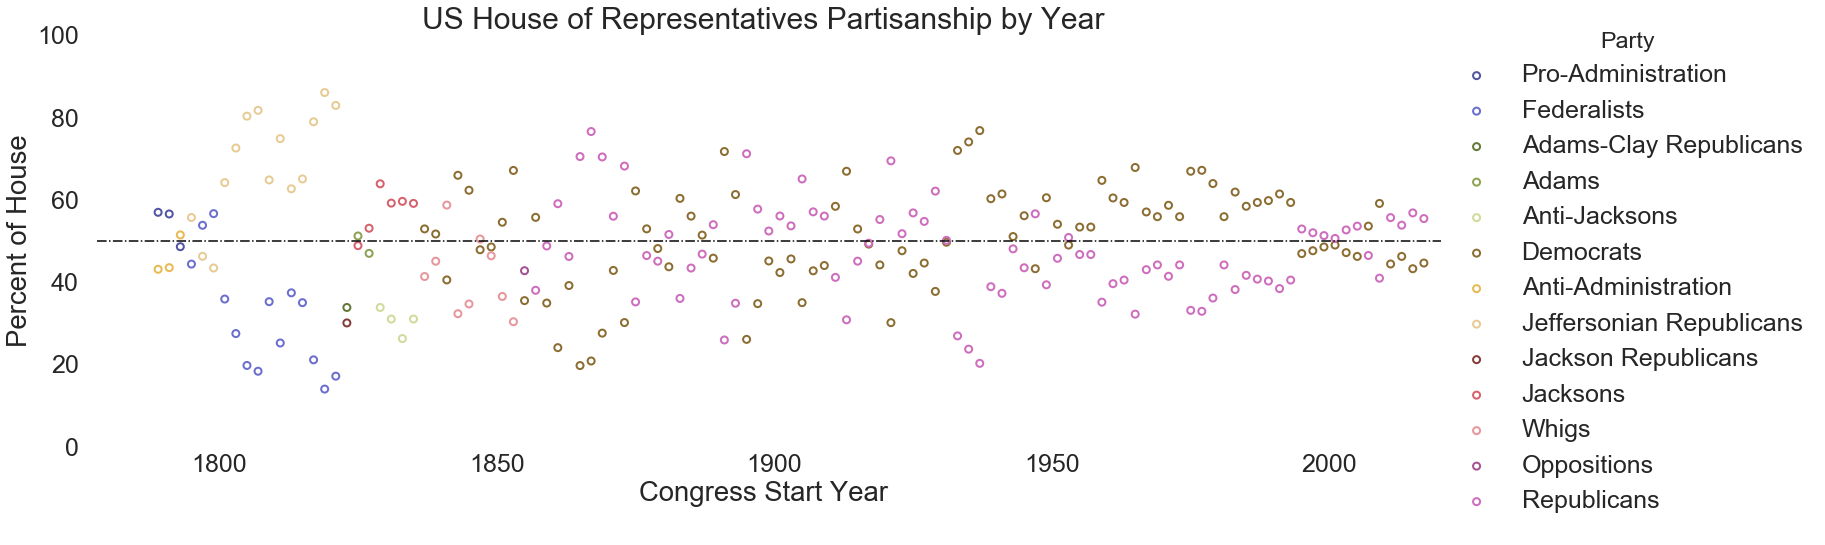

In [26]:
seaborn.set_context("poster")
plt.figure(figsize=(20, 14),dpi=1200)
seaborn.set(font_scale=2.5,rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
seaborn.set_palette(seaborn.color_palette("tab20b", len(_house_parties)))
fg = seaborn.FacetGrid(
    data=house_data, 
    hue='Party',
    hue_order=_house_parties,
    size=7, aspect=3, ylim=(0,100),xlim=(1776, 2020))
fg.map(plt.scatter, 'Start Year', 'Party %', alpha =1.0, facecolors='none',linewidth='2')
plt.plot([1778, 2020], [50, 50], 'k-.', lw=1.5)
fg.add_legend()
plt.ylabel('Percent of House')
plt.xlabel('Congress Start Year')
plt.subplots_adjust(top=1.0)
plt.title('US House of Representatives Partisanship by Year')
plt.savefig('House Partisanship seaborn.png', bbox_inches='tight')
plt.savefig('House Partisanship seaborn.pdf', bbox_inches='tight')

In [27]:
_colors = seaborn.color_palette("husl", len(_house_parties))
_party_color = {k: v for (k,v) in zip(_house_parties, _colors ,)}
_party_marker = {k: v for (k,v) in zip(_house_parties, _markers ,)}

fig, ax = plt.subplots(figsize=(40,20), dpi=600)
for party in _house_parties:
    x = house_data[house_data['Party'] == party]['Start Year']
    y = house_data[house_data['Party'] == party]['Party %']
    ax.scatter(x, y, c=_party_color[party], s = 200, 
               label=party, alpha=0.9, edgecolors='none',  marker=_party_marker[party])


labelsize = 33
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), ncol=5, fontsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.plot([1778, 2020], [50, 50], 'k-.', lw=2.5)
plt.tick_params(axis='both', which='major', labelsize=0.8*labelsize)
plt.title('Percentage of House by Party', fontsize=1.5*labelsize, fontweight='bold')
plt.xlabel('Year', fontsize=labelsize)
plt.ylabel('Percentage (%)', fontsize=labelsize)
plt.axis([1788, 2020, 0, 100])
plt.savefig('House Partisanship with colored markers.png', bbox_inches='tight')
plt.savefig('House Partisanship with colored markers.pdf', bbox_inches='tight')

### Further Improvements for the Plots
As above, to make visualization easier, Tableau, Bokeh, or D3.js could be used to make it so you can select each party individiually. Here I'll export the data to use in Tableau Public.

In [28]:
house_data.to_csv('House Partisanship Data.csv')